In [1]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *

# qiskit-ibmq-provider has been deprecated.
# Please see the Migration Guides in https://ibm.biz/provider_migration_guide for more detail.
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

# Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="ibm_quantum")

# Invoke a primitive. For more details see https://qiskit.org/documentation/partners/qiskit_ibm_runtime/tutorials.html
# result = Sampler("ibmq_qasm_simulator").run(circuits).result()

In [2]:
# useful additional packages
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

from qiskit_aer import Aer
from qiskit.tools.visualization import plot_histogram
from qiskit.circuit.library import TwoLocal
from qiskit_optimization.applications import Maxcut, Tsp
from qiskit.algorithms.minimum_eigensolvers import SamplingVQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import SPSA
from qiskit.utils import algorithm_globals
from qiskit.primitives import Sampler
from qiskit_optimization.algorithms import MinimumEigenOptimizer

In [3]:
def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)
    
def draw_tsp_solution(G, order, colors, pos):
    G2 = nx.DiGraph()
    G2.add_nodes_from(G)
    n = len(order)
    for i in range(n):
        j = (i + 1) % n
        G2.add_edge(order[i], order[j], weight=G[order[i]][order[j]]["weight"])
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(
        G2, node_color=colors, edge_color="b", node_size=600, alpha=0.8, ax=default_axes, pos=pos
    )
    edge_labels = nx.get_edge_attributes(G2, "weight")
    nx.draw_networkx_edge_labels(G2, pos, font_color="b", edge_labels=edge_labels)    

distance
 [[ 0. 43. 40. 29.]
 [43.  0. 53. 72.]
 [40. 53.  0. 54.]
 [29. 72. 54.  0.]]


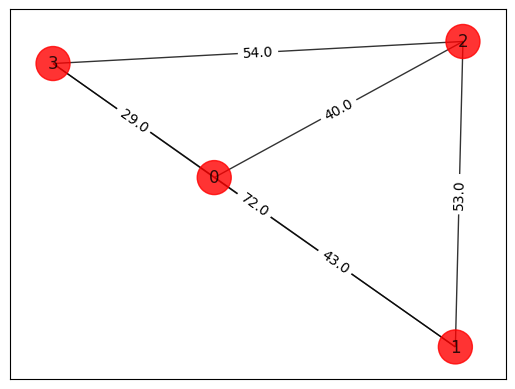

In [9]:
# Generating a graph of 3 nodes
n = 4
num_qubits = n**2
tsp = Tsp.create_random_instance(n, seed=324)
adj_matrix = nx.to_numpy_array(tsp.graph)

print("distance\n", adj_matrix)

colors = ["r" for node in tsp.graph.nodes]
pos = [tsp.graph.nodes[node]["pos"] for node in tsp.graph.nodes]
draw_graph(tsp.graph, colors, pos)

In [10]:
qp = tsp.to_quadratic_program()
print(qp.prettyprint())

Problem name: TSP

Minimize
  43*x_0_0*x_1_1 + 43*x_0_0*x_1_3 + 40*x_0_0*x_2_1 + 40*x_0_0*x_2_3
  + 29*x_0_0*x_3_1 + 29*x_0_0*x_3_3 + 43*x_0_1*x_1_0 + 43*x_0_1*x_1_2
  + 40*x_0_1*x_2_0 + 40*x_0_1*x_2_2 + 29*x_0_1*x_3_0 + 29*x_0_1*x_3_2
  + 43*x_0_2*x_1_1 + 43*x_0_2*x_1_3 + 40*x_0_2*x_2_1 + 40*x_0_2*x_2_3
  + 29*x_0_2*x_3_1 + 29*x_0_2*x_3_3 + 43*x_0_3*x_1_0 + 43*x_0_3*x_1_2
  + 40*x_0_3*x_2_0 + 40*x_0_3*x_2_2 + 29*x_0_3*x_3_0 + 29*x_0_3*x_3_2
  + 53*x_1_0*x_2_1 + 53*x_1_0*x_2_3 + 72*x_1_0*x_3_1 + 72*x_1_0*x_3_3
  + 53*x_1_1*x_2_0 + 53*x_1_1*x_2_2 + 72*x_1_1*x_3_0 + 72*x_1_1*x_3_2
  + 53*x_1_2*x_2_1 + 53*x_1_2*x_2_3 + 72*x_1_2*x_3_1 + 72*x_1_2*x_3_3
  + 53*x_1_3*x_2_0 + 53*x_1_3*x_2_2 + 72*x_1_3*x_3_0 + 72*x_1_3*x_3_2
  + 54*x_2_0*x_3_1 + 54*x_2_0*x_3_3 + 54*x_2_1*x_3_0 + 54*x_2_1*x_3_2
  + 54*x_2_2*x_3_1 + 54*x_2_2*x_3_3 + 54*x_2_3*x_3_0 + 54*x_2_3*x_3_2

Subject to
  Linear constraints (8)
    x_0_0 + x_0_1 + x_0_2 + x_0_3 == 1  'c0'
    x_1_0 + x_1_1 + x_1_2 + x_1_3 == 1  'c1'
    x_2

In [11]:
from qiskit_optimization.converters import QuadraticProgramToQubo

qp2qubo = QuadraticProgramToQubo()
qubo = qp2qubo.convert(qp)
qubitOp, offset = qubo.to_ising()
print("Offset:", offset)
print("Ising Hamiltonian:")
print(str(qubitOp))

Offset: 37846.0
Ising Hamiltonian:
-4714.0 * IIIIIIIIIIIIIIIZ
- 4714.0 * IIIIIIIIIIIIIIZI
- 4714.0 * IIIIIIIIIIIIIZII
- 4714.0 * IIIIIIIIIIIIZIII
- 4742.0 * IIIIIIIIIIIZIIII
- 4742.0 * IIIIIIIIIIZIIIII
- 4742.0 * IIIIIIIIIZIIIIII
- 4742.0 * IIIIIIIIZIIIIIII
- 4731.5 * IIIIIIIZIIIIIIII
- 4731.5 * IIIIIIZIIIIIIIII
- 4731.5 * IIIIIZIIIIIIIIII
- 4731.5 * IIIIZIIIIIIIIIII
- 4735.5 * IIIZIIIIIIIIIIII
- 4735.5 * IIZIIIIIIIIIIIII
- 4735.5 * IZIIIIIIIIIIIIII
- 4735.5 * ZIIIIIIIIIIIIIII
+ 1164.5 * IIIIIIIIIIIIIIZZ
+ 1164.5 * IIIIIIIIIIIIIZIZ
+ 1164.5 * IIIIIIIIIIIIIZZI
+ 1164.5 * IIIIIIIIIIIIZIIZ
+ 1164.5 * IIIIIIIIIIIIZIZI
+ 1164.5 * IIIIIIIIIIIIZZII
+ 1164.5 * IIIIIIIIIIIZIIIZ
+ 10.75 * IIIIIIIIIIIZIIZI
+ 10.75 * IIIIIIIIIIIZZIII
+ 10.75 * IIIIIIIIIIZIIIIZ
+ 1164.5 * IIIIIIIIIIZIIIZI
+ 10.75 * IIIIIIIIIIZIIZII
+ 1164.5 * IIIIIIIIIIZZIIII
+ 10.75 * IIIIIIIIIZIIIIZI
+ 1164.5 * IIIIIIIIIZIIIZII
+ 10.75 * IIIIIIIIIZIIZIII
+ 1164.5 * IIIIIIIIIZIZIIII
+ 1164.5 * IIIIIIIIIZZIIIII
+ 10.75 * IIIIIIIIZI

In [12]:
exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())
result = exact.solve(qubo)
print(result.prettyprint())

objective function value: 179.0
variable values: x_0_0=0.0, x_0_1=1.0, x_0_2=0.0, x_0_3=0.0, x_1_0=1.0, x_1_1=0.0, x_1_2=0.0, x_1_3=0.0, x_2_0=0.0, x_2_1=0.0, x_2_2=0.0, x_2_3=1.0, x_3_0=0.0, x_3_1=0.0, x_3_2=1.0, x_3_3=0.0
status: SUCCESS


energy: -37667.0
tsp objective: 179.0
feasible: True
solution: [1, 0, 3, 2]
solution objective: 179.0


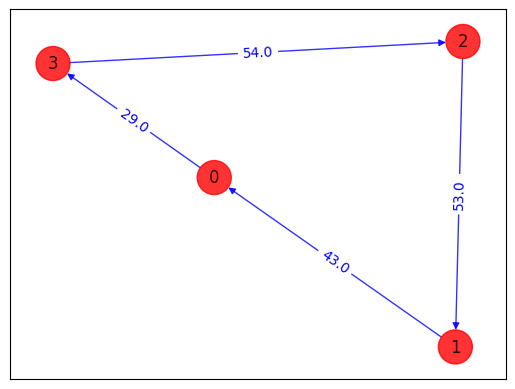

In [13]:
# Making the Hamiltonian in its full form and getting the lowest eigenvalue and eigenvector
ee = NumPyMinimumEigensolver()
result = ee.compute_minimum_eigenvalue(qubitOp)

print("energy:", result.eigenvalue.real)
print("tsp objective:", result.eigenvalue.real + offset)
x = tsp.sample_most_likely(result.eigenstate)
print("feasible:", qubo.is_feasible(x))
z = tsp.interpret(x)
print("solution:", z)
print("solution objective:", tsp.tsp_value(z, adj_matrix))
draw_tsp_solution(tsp.graph, z, colors, pos)